# Machine Learning

In this file, instructions how to approach the challenge can be found.

We are going to work on different types of Machine Learning problems:

- **Regression Problem**: The goal is to predict delay of flights.
- **(Stretch) Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **(Stretch) Binary Classification**: The goal is to predict if the flight will be cancelled.

In [1]:
import pandas as pd
import psycopg2
from psycopg2 import Error
import requests as re
from scipy import stats
from matplotlib import pyplot
import numpy as np
import datetime
from sklearn.preprocessing import OneHotEncoder
from collections import Counter, OrderedDict
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

## Main Task: Regression Problem

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.  

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights **1 week in advance**.

In [2]:
#dataframe with 10,000 results per month to use for modelling, this df has weather data already from weather testing notebook
main_df = pd.read_csv("C:/Users/zain_/LHL/Midterm/midtermrepo/main_df.csv")

In [3]:
#cant use dep_delay, or any of the delays really directly

### Feature Engineering

Feature engineering will play a crucial role in this problems. We have only very little attributes so we need to create some features that will have some predictive power.

- weather: we can use some weather API to look for the weather in time of the scheduled departure and scheduled arrival.
- statistics (avg, mean, median, std, min, max...): we can take a look at previous delays and compute descriptive statistics
- airports encoding: we need to think about what to do with the airports and other categorical variables
- time of the day: the delay probably depends on the airport traffic which varies during the day.
- airport traffic
- unsupervised learning as feature engineering?
- **what are the additional options?**: Think about what we could do more to improve the model.

In [4]:
#take average of all types of delays and add it up to predict delay PER AIRLINE? 
#get airline delay per month per airport?
#dep time to see airport traffic?

In [3]:
#deal with nulls in main_df
main_df = main_df.fillna(value=0)

In [4]:
#drop cancelled flights
main_df = main_df.drop(main_df[main_df.cancelled == 1].index)

In [5]:
#getting mean delay for each airline at each airport
avg_delay_perport = main_df.groupby(['origin','mkt_carrier'])['dep_delay'].mean().reset_index()

In [6]:
#creating a variable with which to link dataframes
main_df['airport_origin'] = main_df.origin+'_'+main_df.mkt_carrier

In [7]:
#creating a variable with which to link dataframes
avg_delay_perport['airport_origin'] = avg_delay_perport.origin+'_'+avg_delay_perport.mkt_carrier

In [8]:
#df with average delay per airline per airport
complete_df = pd.merge(main_df, avg_delay_perport, how='inner', on='airport_origin')

In [9]:
#drop columns not needed anymore
complete_df = complete_df.drop(['airport_origin','origin_y','mkt_carrier_y','carrier_delay', 'weather_delay','nas_delay','security_delay','late_aircraft_delay','dep_delay_x'],axis=1)

In [10]:
#complete df now has weather and avg delay for each airline at each origin airport
complete_df = complete_df.rename(columns={'dep_delay_y':'avg_delay', 'origin_x':'origin','mkt_carrier_x':'mkt_carrier'})

<AxesSubplot:>

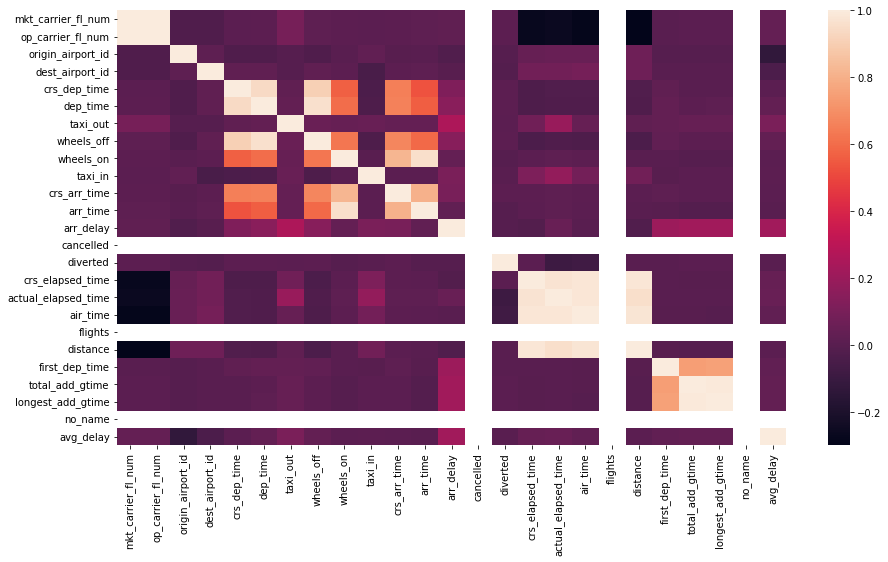

In [11]:
#look at correlations with arrival delay, looking for strong positive and strong negative 
#taxi out has surprisingly high correlation with arr_delay
#can also remove variables that are completely correlated (remove1)
f, ax = plt.subplots(figsize=(15, 8))
corr = complete_df.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [12]:
#drop useless or highly correlated columns, keeping the one more correlated with arr_delay
complete_df = complete_df.drop(['no_name','flights','op_carrier_fl_num', 'wheels_on','wheels_off','crs_elapsed_time','air_time','dep_time','arr_time','dup','cancelled'],axis=1)

<AxesSubplot:>

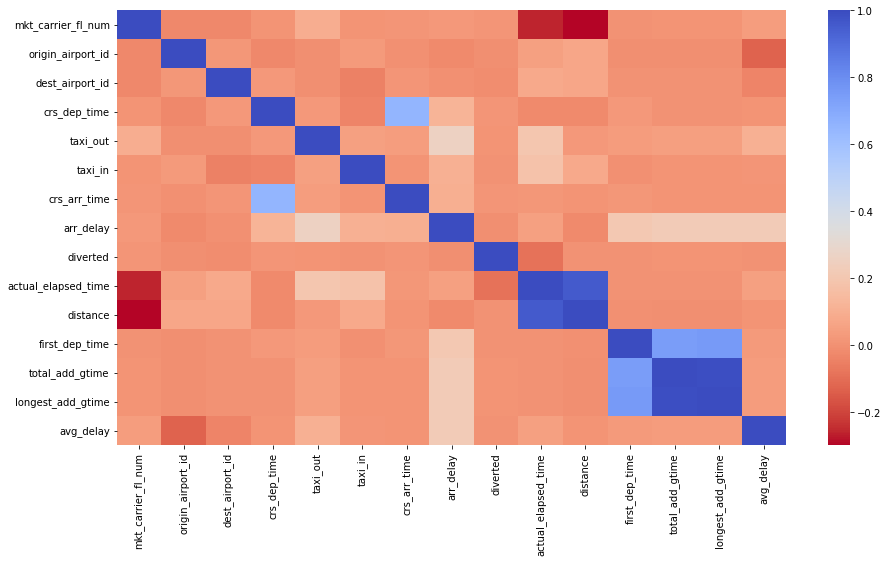

In [13]:
#check correlation matrix after dropping columns
#better heatmap coloring
f, ax = plt.subplots(figsize=(15, 8))
corr = complete_df.corr()
sns.heatmap(corr,
            cmap='coolwarm_r',
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [14]:
#drop more, including columns that shouldnt make a difference 
complete_df = complete_df.drop(['longest_add_gtime','distance','mkt_carrier_fl_num','tail_num','branded_code_share','op_unique_carrier','origin_airport_id','dest_airport_id','cancellation_code',],axis=1)

In [15]:
complete_df['fl_date'] = pd.to_datetime(complete_df['fl_date'], format = '%Y-%m-%d')

In [16]:
#checking that these 2 are the same, then dropping one
complete_df[complete_df['mkt_unique_carrier']!=complete_df['mkt_carrier']]
complete_df = complete_df.drop('mkt_unique_carrier',axis=1)

In [17]:
#onehotencode mkt_carrier, concat to the df
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb_carrier =lb.fit(complete_df['mkt_carrier'])
transformed = lb_carrier.transform(complete_df['mkt_carrier'])
ohe_df = pd.DataFrame(transformed)
completed_df =pd.concat([complete_df, ohe_df], axis=1).drop(['mkt_carrier'], axis=1)

In [18]:
#count dep_time as air traffic
completed_df['count_1']=1
traffic_by_deptime = completed_df.groupby(['crs_dep_time'])['count_1'].count().reset_index()
traffic_added_df = pd.merge(completed_df, traffic_by_deptime, how='inner', on='crs_dep_time')

In [19]:
#delete useless count and rename column
#traffic column now represents air traffic
#this would be better if it added all the flights currently in the air up and dropped ones that had landed, if theres time do this
traffic_added_df = traffic_added_df.drop('count_1_x',axis=1)   
traffic_added_df = traffic_added_df.rename(columns={'count_1_y':'air_traffic'}) 

In [20]:
#now count for local airport traffic
dep_time_origin_count = completed_df.groupby(['crs_dep_time','origin'])['count_1'].count().reset_index().sort_values('count_1')
dep_time_origin_count['crs_dep_time_origin'] = dep_time_origin_count.crs_dep_time.astype(str)+'_'+dep_time_origin_count.origin
traffic_added_df['crs_dep_time_origin'] = traffic_added_df.crs_dep_time.astype(str)+'_'+traffic_added_df.origin
traffic_added = pd.merge(traffic_added_df, dep_time_origin_count, how='inner', on='crs_dep_time_origin')

In [21]:
traffic_added = traffic_added.drop(['crs_dep_time_origin','crs_dep_time_y','origin_y'],axis=1)
traffic_added = traffic_added.rename(columns={'origin_x':'origin','crs_dep_time_x':'crs_dep_time','count_1':'airport_traffic'})

In [22]:
#dont need name of origin and destination or origin and destination anymore i think, since i have created variables out of them that should be enough
traffic_added = traffic_added.drop(['origin','origin_city_name','dest','dest_city_name'],axis=1)

In [23]:
#need to one hot encode weather_condition,
traffic_added.dtypes

fl_date                datetime64[ns]
crs_dep_time                    int64
taxi_out                      float64
taxi_in                       float64
crs_arr_time                    int64
arr_delay                     float64
diverted                        int64
actual_elapsed_time           float64
first_dep_time                float64
total_add_gtime               float64
weather_condition              object
avg_delay                     float64
0                               int32
1                               int32
2                               int32
3                               int32
4                               int32
5                               int32
6                               int32
7                               int32
8                               int32
9                               int32
air_traffic                     int64
airport_traffic                 int64
dtype: object

In [24]:
conditions = traffic_added['weather_condition']

In [25]:
#broader categories for easier ohe
#will need this later so just make a function
def correcting_weather(weath_list):
    conditions = [x.lower() for x in weath_list]
    adjusted_conditions = []
    for ele in conditions:
        if 'fog' in ele:
            adjusted_conditions.append('mist')
        elif 'rain' in ele:
            adjusted_conditions.append('rain')
        elif 'thunder' in ele:
            adjusted_conditions.append('thunder')
        elif 'snow' in ele:
            adjusted_conditions.append('rain')
        elif 'sunny' in ele:
            adjusted_conditions.append('clear')
        else:
            adjusted_conditions.append(ele)
    return adjusted_conditions

In [26]:
adjusted_conditions = correcting_weather(traffic_added['weather_condition'])

In [27]:
traffic_added['weather_condition'] = adjusted_conditions

In [28]:
lb = LabelBinarizer()
lb_weather = lb.fit(traffic_added['weather_condition'])
transformed = lb_weather.transform(traffic_added['weather_condition'])
ohe_df = pd.DataFrame(transformed, columns = ['w0','w1','w2','w3','w4','w5'])

In [29]:
ready_df = pd.concat([traffic_added, ohe_df], axis=1).drop(['weather_condition'], axis=1)

In [30]:
#remove fl_date since it wont be useful in model past the variables created now??
ready_df = ready_df.drop('fl_date',axis=1)

In [31]:
#remove any feature you wont have on submission df since you wont have access to it before the flight has gone
ready_df = ready_df.drop(['actual_elapsed_time','taxi_out','taxi_in','diverted', 'total_add_gtime','first_dep_time'],axis=1)
ready_df.columns

Index([   'crs_dep_time',    'crs_arr_time',       'arr_delay',
             'avg_delay',                 0,                 1,
                       2,                 3,                 4,
                       5,                 6,                 7,
                       8,                 9,     'air_traffic',
       'airport_traffic',              'w0',              'w1',
                    'w2',              'w3',              'w4',
                    'w5'],
      dtype='object')

In [32]:
#out of time to use weather :( drop the dummy encoded weathers
ready_df = ready_df.drop(['w0','w1','w2','w3','w4','w5'],axis=1)

In [33]:
#save this df
ready_df.to_csv('ready_df.csv',index=False)

In [79]:
ready_df

crs_dep_time  crs_arr_time  arr_delay  avg_delay  0  1  2  3  4  5  6  \
0              2110          2335       25.0  11.050000  0  0  0  0  0  0  0   
1              2110          2325       25.0   7.425249  0  0  0  0  0  0  0   
2              2110          2250      -10.0   7.425249  0  0  0  0  0  0  0   
3              2110          2325      -18.0   7.425249  0  0  0  0  0  0  0   
4              2110          2240      -21.0   7.425249  0  0  0  0  0  0  0   
...             ...           ...        ...        ... .. .. .. .. .. .. ..   
68540            47           620       36.0  17.328358  0  0  0  0  1  0  0   
68541            57           635       40.0  17.328358  0  0  0  0  1  0  0   
68542            52           600        5.0  17.328358  0  0  0  0  1  0  0   
68543           355           602       53.0   0.454545  0  0  0  0  1  0  0   
68544           314           625        6.0   0.454545  0  0  0  0  1  0  0   

       7  8  9  air_traffic  airport_traffic  
0      1  0  0          126                5  
1      0  0  1          126                5  
2      0  0  1          126                5  
3      0  0  1          126                5  
4      0  0  1          126                5  
...   .. .. ..          ...              ...  
68540  0  0  0            1                1  
68541  0  0  0            1                1  
68542  0  0  0            1                1  
68543  0  0  0            1                1  
68544  0  0  0            1                1  

[68545 rows x 16 columns]

### Feature Selection / Dimensionality Reduction

We need to apply different selection techniques to find out which one will be the best for our problems.

- Original Features vs. PCA conponents?

In [ ]:
#pca can help reduce noise that the last couple features that dont explain much variance add
#pca is trying to find the direction of the data points kind of, its not as useful for supervised learning
#svd and lda worth considering
#leave this for now

### Modeling

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

In [283]:
#need to scale continuous data but not the one hot encoded data
from sklearn.preprocessing import StandardScaler

In [284]:
columns_to_scale = ready_df.columns.tolist()
del columns_to_scale[4:14]
del columns_to_scale[2]

In [285]:
ohe_columns = [0,1,2,3,4,5,6,7,8,9]

In [286]:
scaler1 = StandardScaler()
scaler2 = StandardScaler()

In [287]:
t_feature = ready_df['arr_delay']
t_feature = t_feature.values
t_feature = t_feature.reshape(-1,1)

In [288]:
nt_features = ready_df.drop('arr_delay',axis=1)

In [289]:
#scale x and y seperatly so unscaling later is easy
scaled_columns_nt = scaler1.fit_transform(nt_features[columns_to_scale]) 
ohe_columns_ = nt_features[ohe_columns]
scaled_column_t = scaler2.fit_transform(t_feature)

In [291]:
scaled_columns = pd.DataFrame(scaled_columns_nt, columns = columns_to_scale)

In [292]:
scaled_df = pd.concat([scaled_columns, ohe_columns_], axis=1)

In [189]:
y = scaled_column_t

In [308]:
import sklearn.model_selection as model_selection
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = model_selection.train_test_split(scaled_df, y, train_size=0.75)

In [148]:
#gridsearch with these models!
#gridsearch multiple models at once? pipeline? this would take so long and if it had an error id be screwed so no
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [149]:
#all those classifier ones wont work

In [309]:
lr = LinearRegression()

In [310]:
lr.fit(X_train, y_train)

LinearRegression()

In [311]:
lry_pred = lr.predict(X_test)

In [312]:
#compare
from sklearn.metrics import r2_score
LRR2 = r2_score(y_test, lry_pred)
LRR2

0.0682338083680214

In [325]:
from sklearn.metrics import mean_squared_error
LRMSE = mean_squared_error(y_test,lry_pred)  

print(LRMSE)

0.9161643064116719


In [335]:
#root mean sqe
lr_rms = mean_squared_error(y_test, lry_pred, squared=False)
lr_rms

0.9571647227158301

In [50]:
parameters_rfr = {'n_estimators': [50,100,300,500], 'max_depth':[10, 20, 50]}

gs_rfr = GridSearchCV(RandomForestRegressor(),parameters_rfr)

In [140]:
#this took incredibly long to run (makes sense given size of passed values and amount of parameter combinations)
gs_rfr.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 20, 50],
                         'n_estimators': [50, 100, 300, 500]})

In [143]:
#BEST IS max_depth=10, n_estimators=300
gs_rfr.best_estimator_

RandomForestRegressor(max_depth=10, n_estimators=300)

In [65]:
rfr = RandomForestRegressor(max_depth = 10, n_estimators = 300)

In [ ]:
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=300)

In [323]:
rfr_y_pred = rfr.predict(X_test)

In [326]:
#better than lr...
RFRR2 = r2_score(y_test, rfr_y_pred)
RFRR2

0.12213664896070864

In [324]:
#mse
RFR_MSE = mean_squared_error(y_test,rfr_y_pred)  

print(RFR_MSE)

0.8631640376653645


In [337]:
#root mean sqe
rfr_rms = mean_squared_error(y_test, rfr_y_pred, squared=False)
rfr_rms

0.9290662181273004

In [338]:
print('Random Forest Regression R2: ', RFRR2)
print('Random Forest Regression MSE: ', RFR_MSE)
print('Random Forest Regression RMSE: ', rfr_rms)

Random Forest Regression R2:  0.12213664896070864
Random Forest Regression MSE:  0.8631640376653645
Random Forest Regression RMSE:  0.9290662181273004


In [70]:
#('linear','poly','rbf','sigmoid'),'C':[1,5,10] original params, left for 6 hours didnt finish
#changed to reduce time and still get results
#read that rbf takes the most time
params_svr = {'kernel':('linear', 'poly'),'C':[1]}
gs_svr = GridSearchCV(SVR(),params_svr)

In [71]:
#fitting taking really long, might have to lower params due to time constaints in next modellings
gs_svr.fit(X_train, y_train)

GridSearchCV(estimator=SVR(),
             param_grid={'C': [1], 'kernel': ('linear', 'poly')})

In [72]:
gs_svr.best_estimator_

SVR(C=1, kernel='poly')

In [75]:
svr = SVR(C = 10, kernel = 'poly')

In [76]:
svr.fit(X_train, y_train)

SVR(C=10, kernel='poly')

In [77]:
svr_y_pred = svr.predict(X_test)

In [78]:
#wow
SVRR2 = r2_score(y_test, svr_y_pred)
SVRR2

-0.01969973322792118

In [ ]:
#SVR models fits worse than a straight line...
#need to go back to feature engineering, inputs are pretty bad right now
#think about why r2 so low... current features are bad predictors (is having dep time and arr time useful? its measuring a difference in the times as an actual difference in value
#between those rows... maybe using different measures would be better?
#created features not so good: air traffic should be summing and dropping as flights land/take off, need more features as well probably

In [ ]:
#need to retrain without weather as i now cant use it in evaluation (out of time), wont do hyperparameter tuning again just use what came out before

### Evaluation

You have data from 2018 and 2019 to develop models. Use different evaluation metrics for each problem and compare the performance of different models.

You are required to predict delays on **out of sample** data from **first 7 days (1st-7th) of January 2020** and to share the file with LighthouseLabs. Sample submission can be found in the file **_sample_submission.csv_**

In [160]:
#need to one hot encode, add features, out of time to pull weather api, need to remove it from model
#load submission df for transformation
sub_df = pd.read_csv("C:/Users/zain_/LHL/Midterm/midtermrepo/submission_data.csv")

In [161]:
#to add avg_delay, need to go back to a dataframe with airlines before ohe, go back and load complete_df with airport_origin column still there
complete_df = pd.merge(main_df, avg_delay_perport, how='inner', on='airport_origin')

In [162]:
transform_middle_df = complete_df['airport_origin']
transform_middle_df = pd.DataFrame(transform_middle_df)
transform_middle_df['avg_delay'] = complete_df['dep_delay_y']

In [163]:
sub_df['airport_origin'] = sub_df.origin+'_'+sub_df.mkt_carrier

In [164]:
sub_df_avgd = pd.merge(sub_df, transform_middle_df, on='airport_origin', how='left',)

In [165]:
#this took long time to run
sub_df_avgd.drop_duplicates(keep='first', inplace=True, ignore_index=True)

In [87]:
#now we have avg_delay

In [166]:
#can use this as a count since for every flight its 1
set(sub_df_avgd['flights'])

{1}

In [167]:
#count dep_time as air traffic
traffic_by_deptime = sub_df_avgd.groupby(['crs_dep_time'])['flights'].count().reset_index()
traffic_added_df = pd.merge(sub_df_avgd, traffic_by_deptime, how='inner', on='crs_dep_time')

In [168]:
#airport traffic
#remember flights_x is used as a count since its 1 for each flight
dep_time_origin_count = traffic_added_df.groupby(['crs_dep_time','origin'])['flights_x'].count().reset_index().sort_values('flights_x')
dep_time_origin_count['crs_dep_time_origin'] = dep_time_origin_count.crs_dep_time.astype(str)+'_'+dep_time_origin_count.origin
traffic_added_df['crs_dep_time_origin'] = traffic_added_df.crs_dep_time.astype(str)+'_'+traffic_added_df.origin
traffic_added = pd.merge(traffic_added_df, dep_time_origin_count, how='inner', on='crs_dep_time_origin')

In [169]:
traffic_added.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin_x',
       'origin_city_name', 'dest_airport_id', 'dest', 'dest_city_name',
       'crs_dep_time_x', 'crs_arr_time', 'dup', 'crs_elapsed_time',
       'flights_x_x', 'distance', 'airport_origin', 'avg_delay', 'flights_y',
       'crs_dep_time_origin', 'crs_dep_time_y', 'origin_y', 'flights_x_y'],
      dtype='object')

In [170]:
#rename/drop some columns to match model df more
traffic_added = traffic_added.drop(['airport_origin','dup','origin_y','crs_dep_time_y','crs_dep_time_origin','flights_x_x', 'fl_date','mkt_unique_carrier','branded_code_share',
                                          'mkt_carrier_fl_num','op_unique_carrier','tail_num','op_carrier_fl_num','origin_airport_id','origin_x','origin_city_name','dest_airport_id','dest', 
                                          'dest_city_name', 'crs_elapsed_time','distance'],axis=1)

In [171]:
traffic_added = traffic_added.rename(columns={'flights_y':'air_traffic','flights_x_y':'airport_traffic','crs_dep_time_x':'crs_dep_time'})

In [172]:
#OHE carrier 
transformed = lb_carrier.transform(traffic_added['mkt_carrier'])
ohe_df = pd.DataFrame(transformed)
complete_sub_df =pd.concat([traffic_added, ohe_df], axis=1).drop(['mkt_carrier'], axis=1)

In [173]:
column_order = list(ready_df.columns)

In [174]:
#reorder to right order
complete_sub_df = complete_sub_df[['crs_dep_time',
 'crs_arr_time',
 'avg_delay',
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 'air_traffic',
 'airport_traffic']]

In [175]:
#put in arr delay just to scale then remove
#fill with mean instead of zero?
complete_sub_df = complete_sub_df.fillna(value=0)

In [176]:
scaled_columns = scaler1.transform(complete_sub_df[columns_to_scale]) 
ohe_columns_sub = complete_sub_df[ohe_columns]
scaled_sub_columns = pd.DataFrame(scaled_columns, columns = columns_to_scale)
scaled_sub_df = pd.concat([scaled_sub_columns, ohe_columns_sub], axis=1)

In [327]:
sub_predict = rfr.predict(scaled_sub_df)

In [328]:
sub_predict = sub_predict.reshape(-1,1)

In [329]:
sub_predict_unscaled = scaler2.inverse_transform(sub_predict)

In [330]:
sub_df = pd.read_csv("C:/Users/zain_/LHL/Midterm/midtermrepo/submission_data.csv")

In [331]:
sub_df.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time',
       'crs_arr_time', 'dup', 'crs_elapsed_time', 'flights', 'distance'],
      dtype='object')

In [332]:
#keep fl_date mkt_carrier mkt_carrier_fl_num origin dest predicted_delay
complete_sub_df = sub_df[['fl_date','mkt_carrier','mkt_carrier_fl_num','origin','dest']]

In [333]:
#the submission dataframe
complete_sub_df['predicted_delay']= sub_predict_unscaled

In [334]:
complete_sub_df.to_csv('submission.csv',index=False)

======================================================================
## Stretch Tasks

### Multiclass Classification

The target variables are **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY**. We need to do additional transformations because these variables are not binary but continuos. For each flight that was delayed, we need to have one of these variables as 1 and others 0.

It can happen that we have two types of delays with more than 0 minutes. In this case, take the bigger one as 1 and others as 0.

### Binary Classification

The target variable is **CANCELLED**. The main problem here is going to be huge class imbalance. We have only very little cancelled flights with comparison to all flights. It is important to do the right sampling before training and to choose correct evaluation metrics.